# Gradient Boosting in scikit-learn

## Setup

In [41]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

## Data

- See [](hitters_data.ipynb) for details about the data preprocessing steps.
- We simply import the preprocessed data by using this [Python script](https://github.com/kirenz/regression/blob/main/docs/hitters_data.py) which will yield:
  - X_train, X_test, y_train, y_test
  - df_train and df_tests



In [42]:
from data_prep_hitters import *

## Model

In [43]:
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

In [44]:
reg = GradientBoostingRegressor(**params)

reg.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=4, min_samples_split=5,
                          n_estimators=500)

In [45]:
mean_squared_error(y_test, reg.predict(X_test))

91723.33713257297

### Plot training deviance

Source: [scikit learn](https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html#plot-training-deviance), provided by Peter Prettenhofer, Maria Telenczuk and Katrina Ni:

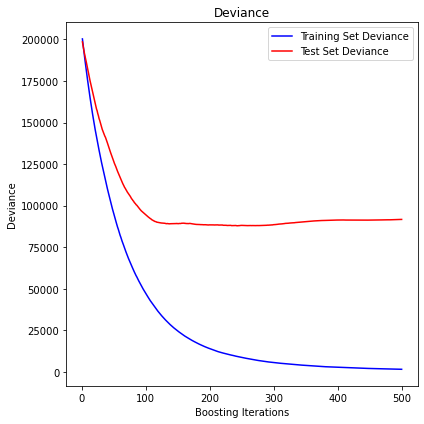

In [46]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)

for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

## Feature importance

- Next, we take a look at the tree based feature importance and the permutation importance.

### Mean decrease in impurity (MDI)

- Mean decrease in impurity (MDI) is a measure of feature importance for decision tree models.

- They are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.

- Note that impurity-based importances are computed on training set statistics and therefore do not reflect the ability of feature to be useful to make predictions that generalize to the test set (when the model has enough capacity).

- Also note that impurity-based importances are biased towards high cardinality features (i.e., features with many unique values). See Permutation feature importance as an alternative below.

- Feature importances are provided by the fitted attribute `feature_importances_` 


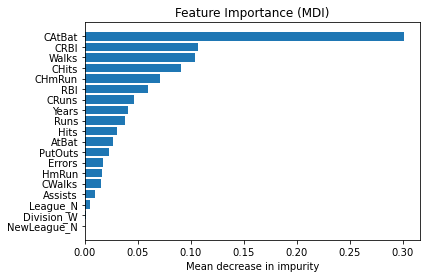

In [47]:
# obtain feature importance
feature_importance = reg.feature_importances_

# sort features according to importance
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0])

# plot feature importances
plt.barh(pos, feature_importance[sorted_idx], align="center")

plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")
plt.xlabel("Mean decrease in impurity");



#### Permutation feature importance

- Permutation feature importance overcomes limitations of the impurity-based feature importance ([scikit learn](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html): 
  - they do not have a bias toward high-cardinality features
  - they can be computed on a left-out test set.

It is a model inspection technique that can be used for any fitted estimator when the data is tabular (see [scikit learn](https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance) for more details):

- The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled. 
- This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature. 
- This technique benefits from being model agnostic and can be calculated many times with different permutations of the feature.
- The permutation importance is calculated on the training set to show how much the model relies on each feature during training.

- Features are shuffled n times and the model refitted to estimate the importance of it. 


Note however that when two features are correlated and one of the features is permuted, the model will still have access to the feature through its correlated feature. This will result in a lower importance value for both features, where they might actually be important. One way to handle this is to cluster features that are correlated and only keep one feature from each cluster. This strategy is explored in this example: [Permutation Importance with Multicollinear or Correlated Features](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#handling-multicollinear-features).

In [48]:
result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=feature_names)

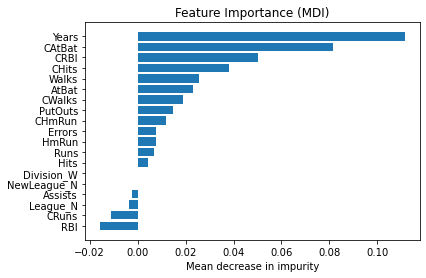

In [49]:
# sort features according to importance
sorted_idx = np.argsort(forest_importances)
pos = np.arange(sorted_idx.shape[0])

# plot feature importances
plt.barh(pos, forest_importances[sorted_idx], align="center")

plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")
plt.xlabel("Mean decrease in impurity");

- Same data plotted as boxplot:

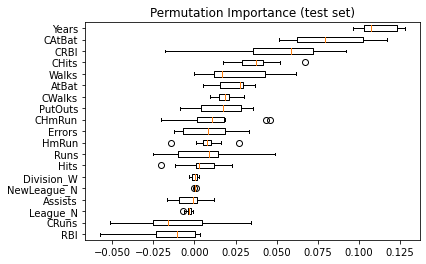

In [50]:
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names)[sorted_idx],
)

plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

- We observe that the same features are detected as most important using both methods (e.g., `CAtBat`, `CRBI`, `CHits`, `Walks`, `Years`). Although the relative importances vary (especially for feature `Years`).